Name: Saleh Abdallah

[GitHub Link](https://github.com/saleh-abdallah/DAAI/blob/main/Intro%20to%20AI/Final%20Project.ipynb)

Objective:

The goal of this project is to develop a machine learning model that can accurately predict loan approval decisions based on the applicants' credit and loan information in order to mimize risk.

In [360]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

--------------------------------------Data Loading--------------------------------------

In [361]:
df = pd.read_csv('loan_data.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [362]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [363]:
# # Remove 'person_' from column names
df.columns = [col.replace('person_', '') for col in df.columns]

In [364]:
df.describe().round(2)

,age,income,emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_cred_hist_length,credit_score,loan_status
count,45000.00,45000.00,45000.00,45000.00,45000.00,45000.00,45000.00,45000.00,45000.00
mean,27.76,80319.05,5.41,9583.16,11.01,0.14,5.87,632.61,0.22
std,6.05,80422.50,6.06,6314.89,2.98,0.09,3.88,50.44,0.42
min,20.00,8000.00,0.00,500.00,5.42,0.00,2.00,390.00,0.00
25%,24.00,47204.00,1.00,5000.00,8.59,0.07,3.00,601.00,0.00
50%,26.00,67048.00,4.00,8000.00,11.01,0.12,4.00,640.00,0.00
75%,30.00,95789.25,8.00,12237.25,12.99,0.19,8.00,670.00,0.00
max,144.00,7200766.00,125.00,35000.00,20.00,0.66,30.00,850.00,1.00


In [365]:
df.describe(include='object')

,gender,education,home_ownership,loan_intent,previous_loan_defaults_on_file
count,45000,45000,45000,45000,45000
unique,2,5,4,6,2
top,male,Bachelor,RENT,EDUCATION,Yes
freq,24841,13399,23443,9153,22858


--------------------------------------Data Cleaning--------------------------------------

In [366]:
# Check for missing values
print('There are', df.isnull().sum().sum(), 'null values in the dataset.')

There are 0 null values in the dataset.


In [367]:
# Check for duplicates
print('There are', df.duplicated().sum(), 'duplicates in the dataset.')

There are 0 duplicates in the dataset.


--------------------------------------EDA--------------------------------------

In [368]:
# Categorical features
categorical_cols = ['gender', 'education', 'home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
# Numerical features
numerical_cols = ['age', 'income', 'emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_cred_hist_length', 'credit_score']

In [369]:
# Check the values in the features 
for i in categorical_cols:
    print(f'\nFeature: {i}')
    print(f'Unique values: {df[i].nunique()}')
    #print(df[i].value_counts())


Feature: gender
Unique values: 2

Feature: education
Unique values: 5

Feature: home_ownership
Unique values: 4

Feature: loan_intent
Unique values: 6

Feature: previous_loan_defaults_on_file
Unique values: 2


In [370]:
# Check the values in the home_ownership column
df['home_ownership'].value_counts()

home_ownership
RENT        23443
MORTGAGE    18489
OWN          2951
OTHER         117
Name: count, dtype: int64

In [371]:
# Drop the Other rows
df = df[df['home_ownership'] != 'OTHER']
df['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE'], dtype=object)

--------------------------------------Univariate Analysis--------------------------------------

In [372]:
# Create a loan_label from the existing loan_status
df['loan_status_label'] = df['loan_status'].map({1: 'Approved', 0: 'Rejected'})

loan_status_label
Rejected    77.8
Approved    22.2
Name: proportion, dtype: float64


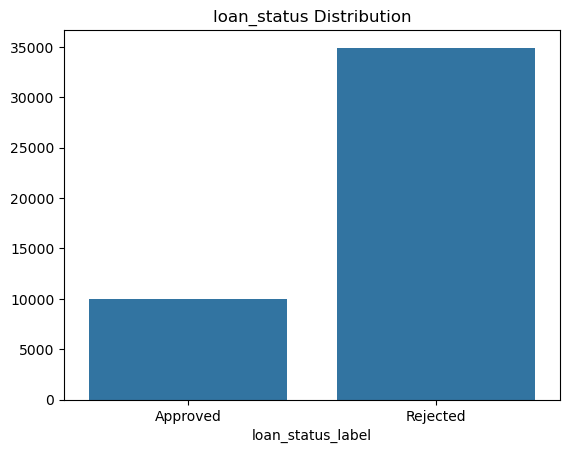

In [373]:
# Target variable distribution
print(df['loan_status_label'].value_counts(normalize=True).round(3)*100)
sns.countplot(x='loan_status_label', data=df)
plt.title('loan_status Distribution')
plt.ylabel('')
plt.show()

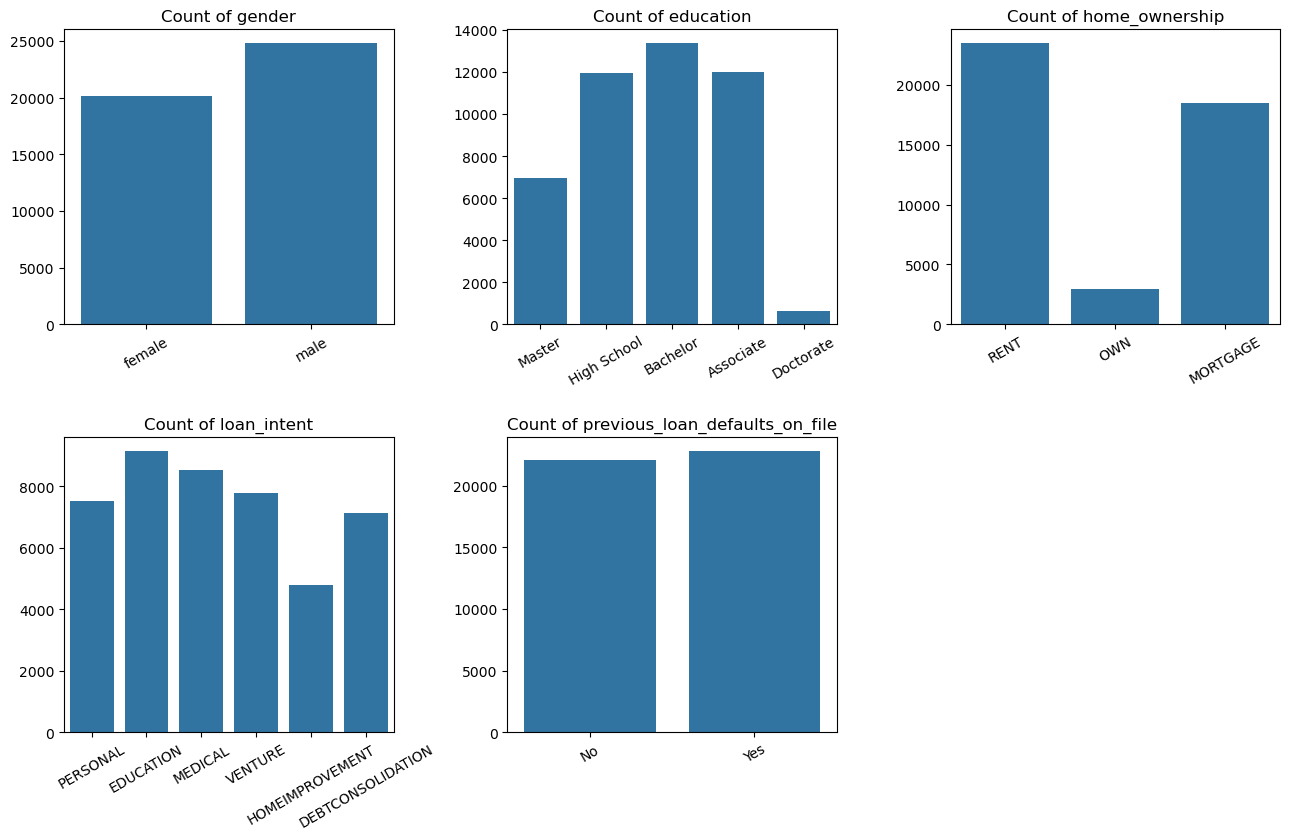

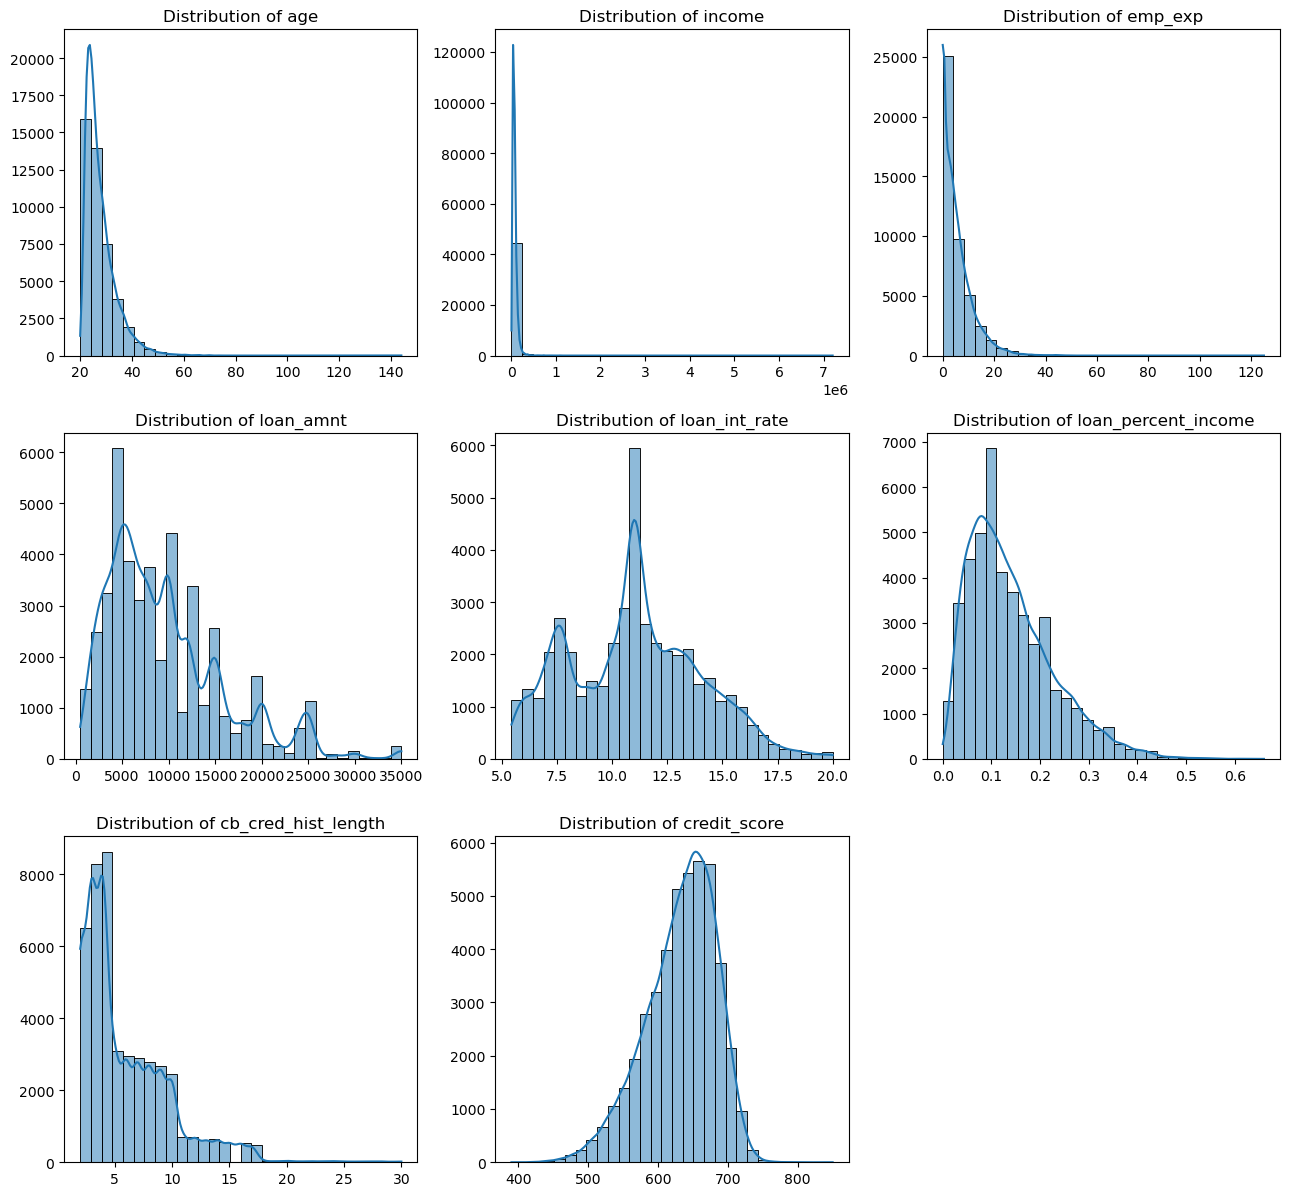

In [374]:
# Count plot
plt.figure(figsize=(13, 32))
for i, x in enumerate(categorical_cols):
    plt.subplot(8, 3, i+1)
    sns.countplot(data=df, x=x)
    plt.title(f'Count of {x}')
    plt.xlabel('')
    plt.xticks(rotation=30)
    plt.ylabel('')
plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(13, 32))
for i, x in enumerate(numerical_cols):
    plt.subplot(8, 3, i+1)
    sns.histplot(df[x], kde=True, bins=30)
    plt.title(f'Distribution of {x}')
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

Insight: 

1. The dataset has imbalanced target variable (loan_status). 

2. The age, income and emp_exp distribution are right-skewed indicating the presence of outliers in these features.

--------------------------------------Bivariate Analysis--------------------------------------

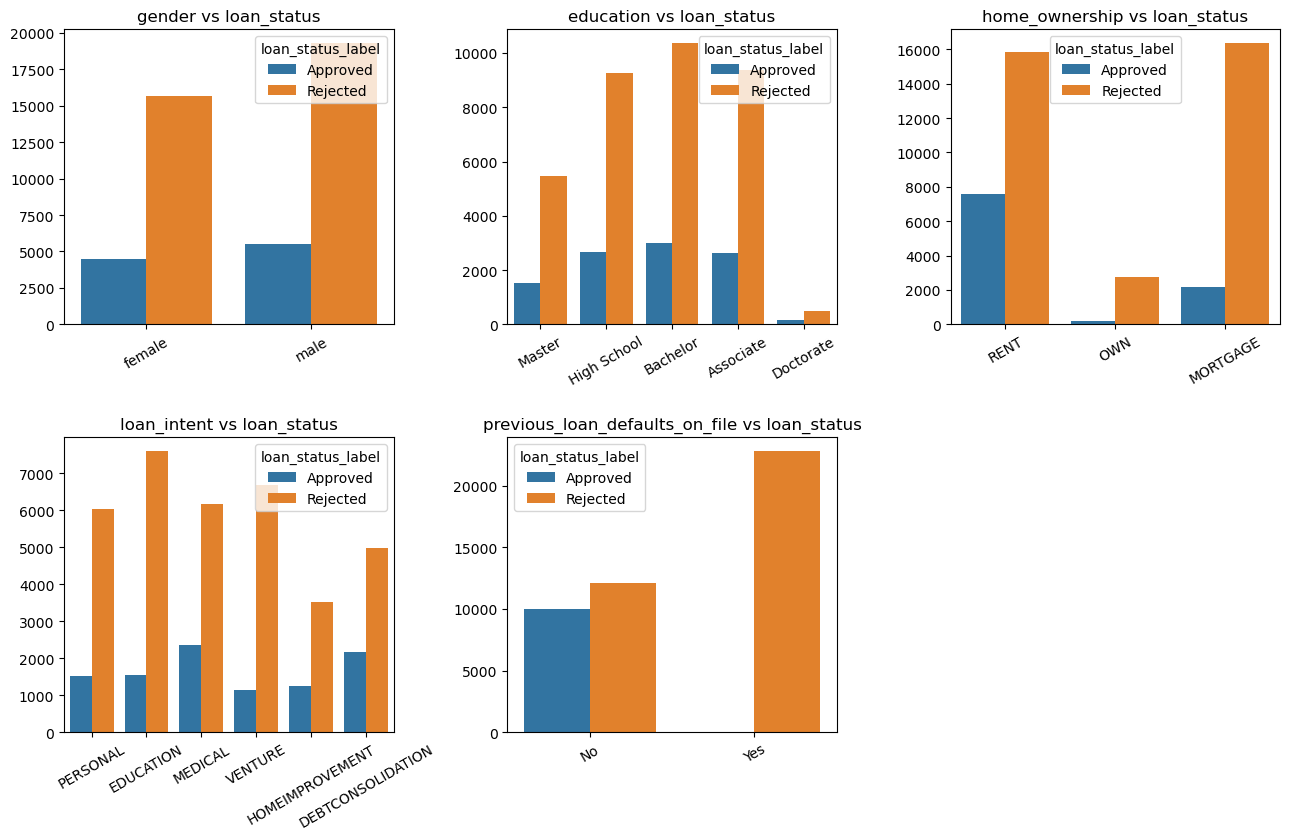

In [375]:
plt.figure(figsize=(13, 32))
for i, x in enumerate(categorical_cols):
    plt.subplot(8, 3, i+1)
    sns.countplot(x=df[x], hue='loan_status_label', data=df)
    plt.title(f'{x} vs loan_status')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Insight: The loan approval rates are consistent across most categories. However, there are two observations: 

1. Customers with a PhD had the lowest approval rates in the education category.

2. In the home ownership category, individuals who own their homes received few approvals compared to those who rent or have a mortgage.

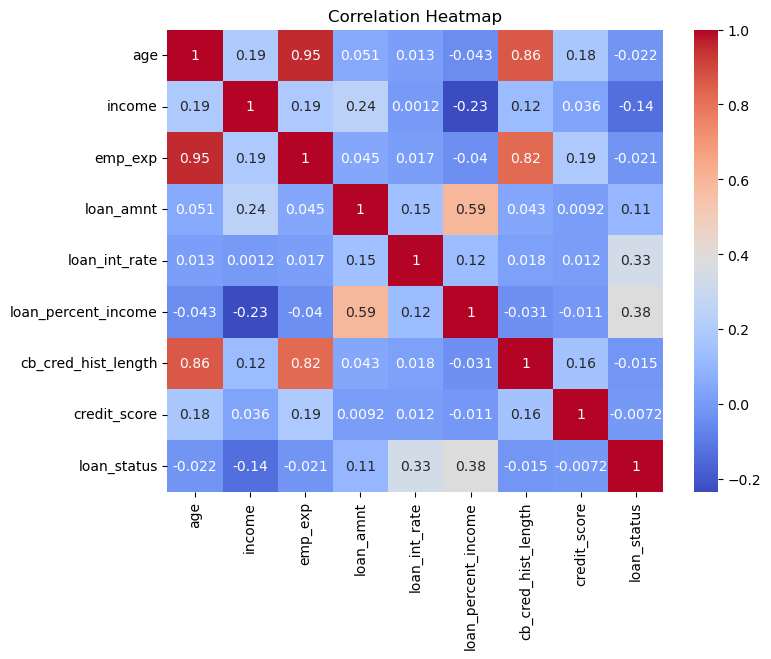

In [376]:
# Correlation matrix
plt.figure(figsize=(8, 6))
corr = df[numerical_cols + ['loan_status']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Insight:

The loan_int_rate and loan_percent_income has somehow the highest correlation to the loan_status but the correlations are generally weak.

--------------------------------------Data Preprocessing--------------------------------------

In [ ]:
# Feature Engineering
# Create a new feature using K-means
scaler = RobustScaler()
feature_scaled = scaler.fit_transform(df[numerical_cols])

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(feature_scaled)

In [378]:
# Feature Encoding - Categorical 
# Binary mapping
df['gender'] = df['gender'].map({'male': 1, 'female': 0})
df['previous_loan_defaults_on_file'] = df['previous_loan_defaults_on_file'].map({'Yes': 1, 'No': 0})

# One-hot encode education and loan_intent
df = pd.get_dummies(df, columns=['home_ownership','education', 'loan_intent'], drop_first=True)

In [379]:
# Data Splitting
X = df.drop(['loan_status','loan_status_label'], axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [380]:
# Feature Scaling - Numerical
# Use RobustScaler since it's less prone to outliers
scaler = RobustScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [381]:
# Handle imbalanced data
# Apply SMOTE - Oversampling minority class
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Apply TomekLinks - Undersampling majority class
tomek = TomekLinks()
X_tomek, y_tomek = tomek.fit_resample(X_train, y_train)

# Apply SMOTETomek (SMOTE + Tomek combined)
smote_tomek = SMOTETomek(random_state=42)
X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X_train, y_train)

# Apply ADASYN- Oversampling
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

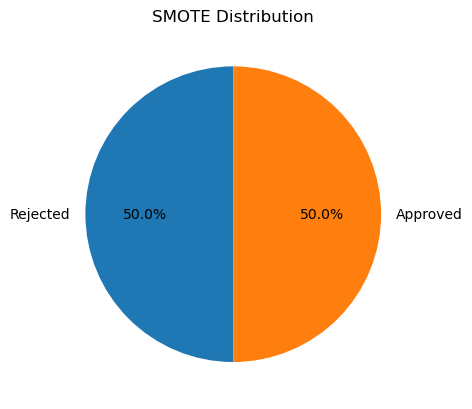

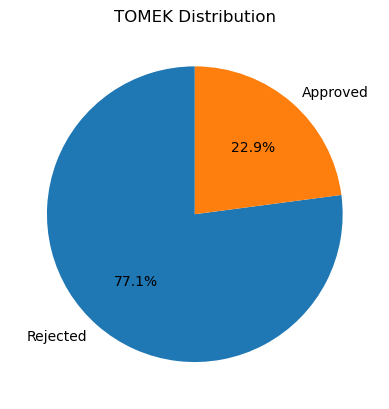

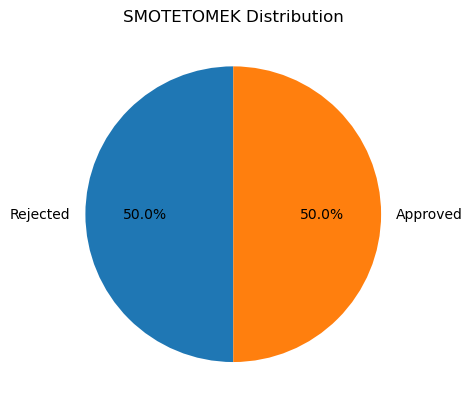

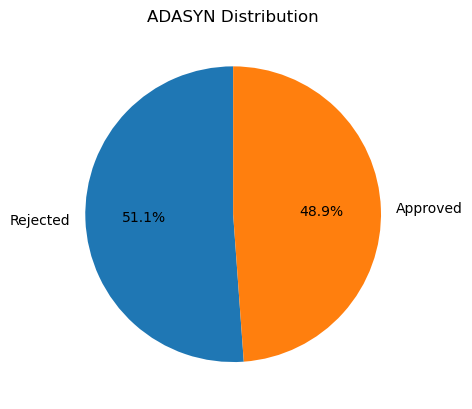

In [382]:
# Define plot distribution function
def resampling_plot(y_resampled, title):
    pd.Series(y_resampled).value_counts().plot.pie(autopct='%1.1f%%', startangle=90, labels=['Rejected', 'Approved'])
    plt.title(title)
    plt.ylabel('')
    plt.show()

resampling_plot(y_smote, 'SMOTE Distribution')
resampling_plot(y_tomek, 'TOMEK Distribution')
resampling_plot(y_smote_tomek, 'SMOTETOMEK Distribution')
resampling_plot(y_adasyn, 'ADASYN Distribution')

--------------------------------------Model Training & Evaluation--------------------------------------

In [383]:
# Logistic Regression, Decision Tree & Random Forest 
classification_models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree Classifier': DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=5, class_weight='balanced', random_state=42),
    'XGBoost Classifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

--------------------------------------Resampling Evaluation--------------------------------------

In [384]:
for name, (X_res, y_res) in {
    'SMOTE': (X_smote, y_smote),
    'ADASYN': (X_adasyn, y_adasyn),
    'SMOTETomek': (X_smote_tomek, y_smote_tomek)
}.items():
    print(f'\n{name}')
    for model_name, model in classification_models.items():
        scores = cross_val_score(model, X_res, y_res, cv=cv, scoring='f1')
        print(f'{model_name}:\n Avg F1 = {scores.mean():.4f} STD = {scores.std():.4f}')


SMOTE
Logistic Regression:
 Avg F1 = 0.8906 STD = 0.0020
Decision Tree Classifier:
 Avg F1 = 0.8745 STD = 0.0036
Random Forest Classifier:
 Avg F1 = 0.9148 STD = 0.0040
XGBoost Classifier:
 Avg F1 = 0.9521 STD = 0.0015

ADASYN
Logistic Regression:
 Avg F1 = 0.8805 STD = 0.0023
Decision Tree Classifier:
 Avg F1 = 0.8638 STD = 0.0034
Random Forest Classifier:
 Avg F1 = 0.9079 STD = 0.0015
XGBoost Classifier:
 Avg F1 = 0.9539 STD = 0.0015

SMOTETomek
Logistic Regression:
 Avg F1 = 0.8921 STD = 0.0031
Decision Tree Classifier:
 Avg F1 = 0.8755 STD = 0.0061
Random Forest Classifier:
 Avg F1 = 0.9163 STD = 0.0041
XGBoost Classifier:
 Avg F1 = 0.9518 STD = 0.0027


Insight:

SMOTETomek has a well balanced overall F1 scores across all models and although it has a bit higher std.

In [385]:
# Apply SMOTETomek to X and y resampled
X_resampled, y_resampled = X_smote_tomek, y_smote_tomek

--------------------------------------Cross Validation - GridSearch Setup--------------------------------------

In [386]:
# Logistic Regression
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

# Decision Tree
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Random Forest Parameters
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

# XGBoost Parameters
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

--------------------------------------Hyperparameter Tuning--------------------------------------

In [387]:
# Logistic Regression
lr_grid = GridSearchCV(
    LogisticRegression(),
    lr_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Decision Tree
dt_grid = GridSearchCV(
    DecisionTreeClassifier(),
    dt_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Random Forest
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# XGBoost
xgb_grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    xgb_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

--------------------------------------Model Training--------------------------------------

Fit each model with the best parameters from GridSearch

In [388]:
# Logistic Regression
lr_grid.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='f1')

In [389]:
# Decision Tree
dt_grid.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1')

In [390]:
# Random Forest
rf_grid.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1')

In [391]:
#XGBoost
xgb_grid.fit(X_resampled, y_resampled)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='f1')

In [392]:
# Logistic Regression best parameters
best_lr = lr_grid.best_estimator_
# Decision Tree best parameters
best_dt = dt_grid.best_estimator_
# Random Forest best parameters
best_rf = rf_grid.best_estimator_
# XGBoost best parameters
best_xgb = xgb_grid.best_estimator_

print("Best LR Params:", lr_grid.best_params_)
print("Best DT Params:", dt_grid.best_params_)
print("Best RF Params:", rf_grid.best_params_)
print("Best XGB Params:", xgb_grid.best_params_)

Best LR Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best DT Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best RF Params: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best XGB Params: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


--------------------------------------Model Evaluation & Metrics--------------------------------------

In [393]:
# Logistic Regression predictions
lr_preds = best_lr.predict(X_test)
# Decision Tree predictions
dt_preds = best_dt.predict(X_test)
# Random Forest predictions
rf_preds = best_rf.predict(X_test)
# XGBoost predictions
xgb_preds = best_xgb.predict(X_test)

print("Logistic Regression Report:\n", classification_report(y_test, lr_preds))
print("Decision Tree Report:\n", classification_report(y_test, dt_preds))
print("Random Forest Report:\n", classification_report(y_test, rf_preds))
print("XGBoost Report:\n", classification_report(y_test, xgb_preds))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.97      0.84      0.90      6997
           1       0.62      0.91      0.74      1980

    accuracy                           0.86      8977
   macro avg       0.79      0.88      0.82      8977
weighted avg       0.89      0.86      0.86      8977

Decision Tree Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      6997
           1       0.70      0.80      0.74      1980

    accuracy                           0.88      8977
   macro avg       0.82      0.85      0.83      8977
weighted avg       0.89      0.88      0.88      8977

Random Forest Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      6997
           1       0.74      0.87      0.80      1980

    accuracy                           0.90      8977
   macro avg       0.85      0.89      0.87      8977

--------------------------------------Interpretation of Results--------------------------------------

XGBoost outperforms the other models as shown below:

1. XGBoost has the highest accuracy at 93%, compared to Random Forest 90%, Decision Tree’s 88%, and Logistic Regression’s 86%.

2. XGBoost has the highest precision for class 1 (approved loans) at 86%, indicating fewer false positives which means better risk mitigation, vs 74% for Random Forest, 70% for Decision Tree, and 62% for Logistic Regression.

3. Random Forest has a slightly higher recall (87%) than XGBoost (82%), but this is a less priority compared to precision especially since the difference is minimal.

Finally, XGBoost balances high precision and strong recall with the highest overall accuracy and F1-score, making it the best model to reduce loan approval risk through minimizing false positives while maintaining good detection of true approvals.